# Imports

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.utils import Bunch


# Load image data

In [2]:
import cv2


def crop_image(raw_image, dimension):
    x = raw_image.shape[1]/2 - dimension[1]/2
    y = raw_image.shape[0]/2 - dimension[0]/2
    return raw_image[int(y):int(y+dimension[0]), int(x):int(x+dimension[1])]


def load_image_files(images_dir_path, dimension=(224, 224), test_split_size=0.5):
    images_dir = Path(images_dir_path)
    directories = [directory for directory in images_dir.iterdir()]
    classes = [class_directory.name.lower() for class_directory in directories]

    train_data = []
    test_data = []

    for class_index, directory in enumerate(directories):
        class_images_cnt = 0
        for file in directory.iterdir():
            class_images_cnt += 1

        for i, file in enumerate(directory.iterdir()):
            image = cv2.imread(file.as_posix(), cv2.IMREAD_COLOR)
            image = cv2.resize(image, dimension)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = (image / 255.0) * 2 - 1
            image_flat = image.flatten()

            bunch = Bunch(
                image=image,
                image_resized=image,
                image_flat=image_flat,
                class_index=class_index,
                class_name=classes[class_index],
            )

            if i < int(class_images_cnt * test_split_size):
                test_data.append(bunch)
                continue

            train_data.append(bunch)

    return (train_data, test_data)

train_dataset, test_dataset = load_image_files("groceries", dimension=(112, 112))
# train_dataset, test_dataset = load_image_files("cifar-10", dimension=(64, 64))
print(len(train_dataset))
print(len(test_dataset))

2480
2467


In [3]:
max(train_dataset[0].image_flat * 2 - 1)

0.7019607843137257

# Render sample dataset image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


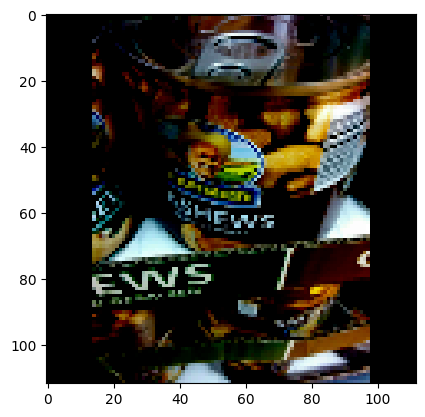

nuts


In [4]:
import random
%matplotlib inline

sample_image_index = random.randint(0, len(train_dataset))

plt.imshow(train_dataset[sample_image_index].image)
plt.show()
print(train_dataset[sample_image_index].class_name)

# Transform data into NDArray's

In [5]:
x_train = np.asarray(list(map(lambda train_bunch: train_bunch.image_flat, train_dataset)))
x_test = np.asarray(list(map(lambda test_bunch: test_bunch.image_flat, test_dataset)))
y_train = np.asarray(list(map(lambda train_bunch: train_bunch.class_index, train_dataset)))
y_test = np.asarray(list(map(lambda test_bunch: test_bunch.class_index, test_dataset)))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2480, 37632)
(2467, 37632)
(2480,)
(2467,)


# Train RandomForest classifier

In [7]:
import cv2

rf = cv2.ml.RTrees_create()
rf.train(x_train.astype(np.float32), cv2.ml.ROW_SAMPLE, y_train)


True

In [8]:
y_pred = rf.predict(x_test.astype(np.float32))[1]

In [9]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.00      0.00      0.00        54
           2       0.00      0.00      0.00        84
           3       0.36      0.45      0.40       131
           4       0.00      0.00      0.00        75
           5       0.00      0.00      0.00        90
           6       0.18      0.14      0.16        85
           7       0.00      0.00      0.00        81
           8       0.36      0.05      0.09        78
           9       0.13      0.80      0.22       153
          10       0.00      0.00      0.00        88
          11       0.00      0.00      0.00        86
          12       0.16      0.26      0.20       141
          13       0.00      0.00      0.00        92
          14       0.21      0.11      0.15       151
          15       0.35      0.05      0.09       149
          16       0.00      0.00      0.00        68
          17       0.00    

/Users/plenkinav/Projects/opencv-classifiers/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/plenkinav/Projects/opencv-classifiers/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/plenkinav/Projects/opencv-classifiers/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [10]:
# svm.save("svm_cifar10_12288_f32.dat")
rf.save("rf_groceries_37632_f32.dat")

In [12]:
# svm = cv2.ml.SVM_load("svm_cifar10_12544_f32.dat")
rf = cv2.ml.RTrees_load("rf_groceries_37632_f32.dat")
y_pred = rf.predict(x_test.astype(np.float32))[1]